In [1]:
# Importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from PIL import Image
import requests
from io import BytesIO
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Embedding
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.callbacks import LearningRateScheduler
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras import regularizers
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from keras.callbacks import EarlyStopping
from nltk import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sean\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Set seed values to constant for reproduceability
seed=42
keras.utils.set_random_seed(seed)

In [3]:
# Load card data from spreadsheet
import ast
import os

card_df=pd.read_csv('card_data.csv')

card_df.head()

,Unnamed: 0,id,name,type,frameType,desc,race,archetype,card_sets,card_images,...,atk,def,level,attribute,pend_desc,monster_desc,scale,linkval,linkmarkers,banlist_info
0,0,34541863,"""A"" Cell Breeding Device",Spell Card,spell,"During each of your Standby Phases, put 1 A-Co...",Continuous,Alien,"[{'set_name': 'Force of the Breaker', 'set_cod...","[{'id': 34541863, 'image_url': 'https://images...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,64163367,"""A"" Cell Incubator",Spell Card,spell,Each time an A-Counter(s) is removed from play...,Continuous,Alien,"[{'set_name': ""Gladiator's Assault"", 'set_code...","[{'id': 64163367, 'image_url': 'https://images...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,91231901,"""A"" Cell Recombination Device",Spell Card,spell,Target 1 face-up monster on the field; send 1 ...,Quick-Play,Alien,"[{'set_name': 'Invasion: Vengeance', 'set_code...","[{'id': 91231901, 'image_url': 'https://images...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,73262676,"""A"" Cell Scatter Burst",Spell Card,spell,"Select 1 face-up ""Alien"" monster you control. ...",Quick-Play,Alien,"[{'set_name': 'Strike of Neos', 'set_code': 'S...","[{'id': 73262676, 'image_url': 'https://images...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,98319530,"""Infernoble Arms - Almace""",Spell Card,spell,While this card is equipped to a monster: You ...,Equip,Noble Knight,"[{'set_name': 'Duelist Nexus', 'set_code': 'DU...","[{'id': 98319530, 'image_url': 'https://images...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Tidying up data
1) Removed features that are unrelated to the card prices, such as the number and id.
2) Removed features that are repeated (such as pend_desc and monster_desc, both of which are already included in desc, also type, which overlaps with frameType.
3) Dropped some rows with missing information, such as some rows from card_sets.
4) filled empty cells with 0, as all the values are intentionally missing due to the properties of the cards (e.g. Spell and Trap cards do not have Attack and Defence points).
5) split up nested cells into multiple columns, such as card_sets and card_prices, which contain multivariate features but are shown in only 1 single cell.

In [4]:
#drop all empty card sets
card_df=card_df.dropna(subset='card_sets')
# card_df = card_df.sample(n=2000), random_state=42)

# Remove descriptions for Normal monsters
card_df['desc']=[str(card_df['desc'].iloc[x]) if (card_df['type'].iloc[x]!='Normal Monster') else '' for x in range(len(card_df)) ]
card_df['cardlength']=[len(word_tokenize(x.translate(str.maketrans('', '', string.punctuation)))) for x in card_df['desc']]

#seperate card sets into individual columns
temp=[ast.literal_eval(x) for x in card_df['card_sets'].values]
card_df['reprints']=[len(temp[x]) for x in range(len(temp))]
card_df['set_name']=[temp[x][0]['set_name'] for x in range(len(temp))]
card_df['set_rarity']=[temp[x][0]['set_rarity'] for x in range(len(temp))]
card_df['set_rarity_code']=[temp[x][0]['set_rarity_code'] for x in range(len(temp))]
card_df['set_price']=[temp[x][0]['set_price'] for x in range(len(temp))]
card_df=card_df.drop(['card_sets'],axis=1)

#seperate card images into individual columns
card_images=[ast.literal_eval(x) for x in card_df['card_images'].values]
image_url=[card_images[x][0]['image_url'] for x in range(len(card_images))]
image_url_small=[card_images[x][0]['image_url_small'] for x in range(len(card_images))]
image_url_cropped=[card_images[x][0]['image_url_cropped'] for x in range(len(card_images))]

#obtain images through the urls obtained
# dispimages=[Image.open(BytesIO(requests.get(x).content)) for x in image_url]
# card_df['card_images']=dispimages

#seperate card prices into individual columns
temp=[ast.literal_eval(x) for x in card_df['card_prices'].values]
card_df['cardmarket_price']=[float(temp[x][0]['cardmarket_price']) for x in range(len(temp))]
card_df['tcgplayer_price']=[float(temp[x][0]['tcgplayer_price']) for x in range(len(temp))]
card_df['ebay_price']=[float(temp[x][0]['ebay_price']) for x in range(len(temp))]
card_df['amazon_price']=[float(temp[x][0]['amazon_price']) for x in range(len(temp))]
card_df['coolstuffinc_price']=[float(temp[x][0]['coolstuffinc_price']) for x in range(len(temp))]
card_df=card_df.drop(['card_prices'],axis=1)

#drop unwanted columns
carddesc=card_df['desc']
card_df=card_df.drop(['card_images'],axis=1)
card_df=card_df.drop(['Unnamed: 0','id','frameType','pend_desc','monster_desc','desc','set_rarity_code','linkmarkers'],axis=1)

card_df=card_df.fillna(-1)

card_df.head(5)

,name,type,race,archetype,atk,def,level,attribute,scale,linkval,...,cardlength,reprints,set_name,set_rarity,set_price,cardmarket_price,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price
0,"""A"" Cell Breeding Device",Spell Card,Continuous,Alien,-1.0,-1.0,-1.0,-1,-1.0,-1.0,...,16,1,Force of the Breaker,Common,1.31,0.10,0.19,0.99,24.45,0.25
1,"""A"" Cell Incubator",Spell Card,Continuous,Alien,-1.0,-1.0,-1.0,-1,-1.0,-1.0,...,32,1,Gladiator's Assault,Common,2.1,0.07,0.24,1.25,0.50,0.25
2,"""A"" Cell Recombination Device",Spell Card,Quick-Play,Alien,-1.0,-1.0,-1.0,-1,-1.0,-1.0,...,66,1,Invasion: Vengeance,Common,1.12,0.10,0.20,0.99,0.50,0.49
3,"""A"" Cell Scatter Burst",Spell Card,Quick-Play,Alien,-1.0,-1.0,-1.0,-1,-1.0,-1.0,...,22,1,Strike of Neos,Common,1.13,0.12,0.10,2.00,9.76,0.25
4,"""Infernoble Arms - Almace""",Spell Card,Equip,Noble Knight,-1.0,-1.0,-1.0,-1,-1.0,-1.0,...,89,2,Duelist Nexus,Quarter Century Secret Rare,0,0.00,0.64,0.00,0.00,0.00


## Encoding the categorical features

In [5]:
# Produces dictionaries for all the encoded categories if needed
card_df_val=card_df

dict_type=dict(enumerate(card_df.type.astype('category').cat.categories))
card_df_val.type=card_df_val.type.astype('category').cat.codes

card_df_val.race=card_df_val.race.astype('category').cat.codes
dict_race=dict(enumerate(card_df.race.astype('category').cat.categories))
card_df_val.archetype=card_df_val.archetype.astype('category').cat.codes
dict_archetype=dict(enumerate(card_df.archetype.astype('category').cat.categories))
card_df_val.banlist_info=card_df_val.banlist_info.astype('category').cat.codes
dict_banlist_info=dict(enumerate(card_df.banlist_info.astype('category').cat.categories))
card_df_val.attribute=card_df_val.attribute.astype('category').cat.codes
dict_attribute=dict(enumerate(card_df.attribute.astype('category').cat.categories))
card_df_val.set_name=card_df_val.set_name.astype('category').cat.codes
dict_set_name=dict(enumerate(card_df.set_name.astype('category').cat.categories))
card_df_val.set_rarity=card_df_val.sort_values(by=['set_rarity']).set_rarity.astype('category').cat.codes

card_df.head(5)

,name,type,race,archetype,atk,def,level,attribute,scale,linkval,...,cardlength,reprints,set_name,set_rarity,set_price,cardmarket_price,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price
0,"""A"" Cell Breeding Device",16,18,14,-1.0,-1.0,-1.0,0,-1.0,-1.0,...,16,1,195,2,1.31,0.10,0.19,0.99,24.45,0.25
1,"""A"" Cell Incubator",16,18,14,-1.0,-1.0,-1.0,0,-1.0,-1.0,...,32,1,206,2,2.1,0.07,0.24,1.25,0.50,0.25
2,"""A"" Cell Recombination Device",16,59,14,-1.0,-1.0,-1.0,0,-1.0,-1.0,...,66,1,217,2,1.12,0.10,0.20,0.99,0.50,0.49
3,"""A"" Cell Scatter Burst",16,59,14,-1.0,-1.0,-1.0,0,-1.0,-1.0,...,22,1,403,2,1.13,0.12,0.10,2.00,9.76,0.25
4,"""Infernoble Arms - Almace""",16,28,318,-1.0,-1.0,-1.0,0,-1.0,-1.0,...,89,2,160,19,0,0.00,0.64,0.00,0.00,0.00


## Data visualization of Input and Output Data

In [6]:
#Input Data
card_df_val.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
type,12374.0,10.200016,9.778390,0.0,0.00,8.00,18.00,27.00
race,12374.0,44.891789,20.822593,0.0,28.00,52.00,59.00,85.00
archetype,12374.0,144.009940,162.484927,0.0,0.00,73.00,280.00,494.00
atk,12374.0,964.165751,1043.938384,-1.0,-1.00,700.00,1800.00,5000.00
def,12374.0,773.558752,916.687875,-1.0,-1.00,300.00,1500.00,5000.00
level,12374.0,2.445531,3.312697,-1.0,-1.00,3.00,4.00,13.00
attribute,12374.0,2.338209,2.374662,0.0,0.00,1.00,5.00,7.00
scale,12374.0,-0.856150,0.996800,-1.0,-1.00,-1.00,-1.00,13.00
linkval,12374.0,-0.894941,0.613398,-1.0,-1.00,-1.00,-1.00,6.00
banlist_info,12374.0,0.276144,2.103662,0.0,0.00,0.00,0.00,25.00


In [7]:
# Output data
card_df_val.iloc[:,16:].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cardmarket_price,12374.0,1.102520,12.514694,0.0,0.09,0.15,0.32,985.44
tcgplayer_price,12374.0,1.206034,18.758122,0.0,0.13,0.20,0.40,999.99
ebay_price,12374.0,4.180996,29.553742,0.0,0.99,1.25,2.75,999.99
amazon_price,12374.0,4.004826,22.138586,0.0,0.25,0.97,1.99,999.99
coolstuffinc_price,12374.0,1.409521,11.782775,0.0,0.25,0.39,0.79,999.99


array([[<Axes: title={'center': 'type'}>,
        <Axes: title={'center': 'race'}>,
        <Axes: title={'center': 'archetype'}>,
        <Axes: title={'center': 'atk'}>],
       [<Axes: title={'center': 'def'}>,
        <Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'attribute'}>,
        <Axes: title={'center': 'scale'}>],
       [<Axes: title={'center': 'linkval'}>,
        <Axes: title={'center': 'banlist_info'}>,
        <Axes: title={'center': 'cardlength'}>,
        <Axes: title={'center': 'reprints'}>],
       [<Axes: title={'center': 'set_name'}>,
        <Axes: title={'center': 'set_rarity'}>, <Axes: >, <Axes: >]],
      dtype=object)

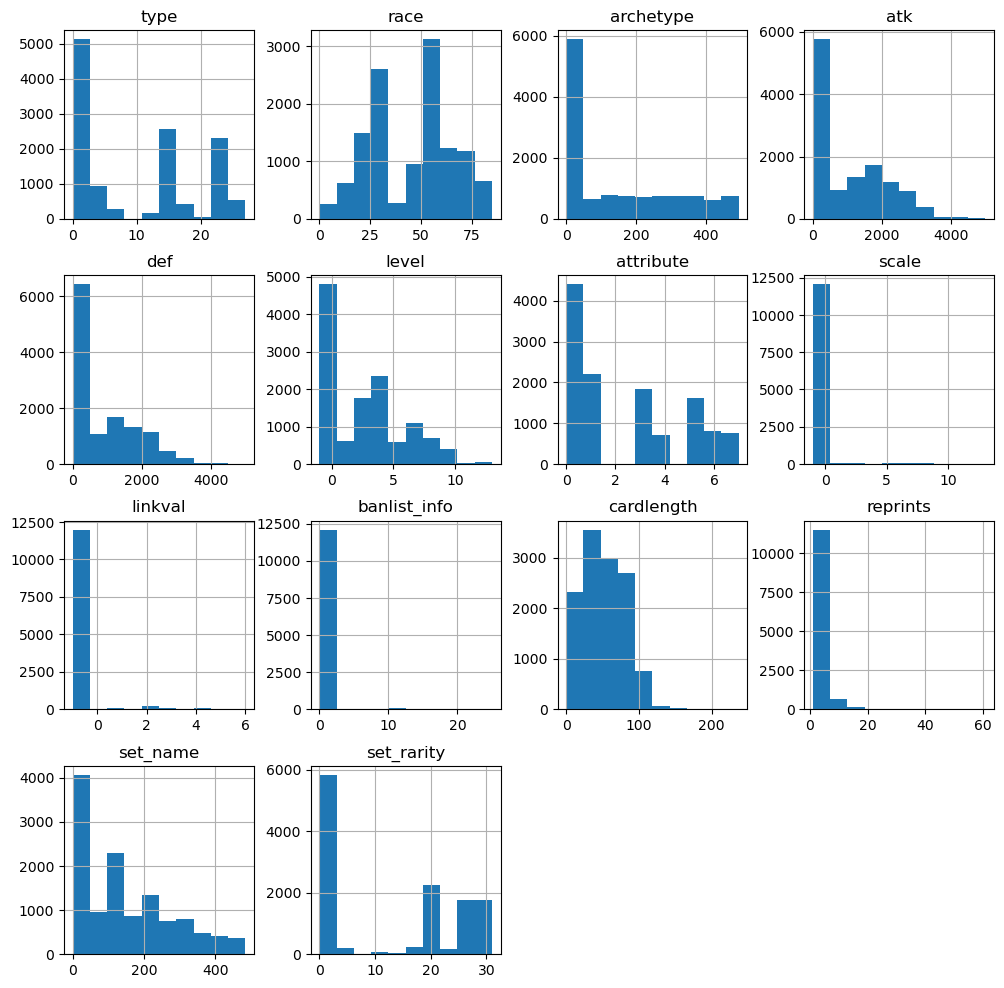

In [8]:
# Distribution of the input features
card_df_val.iloc[:,0:16].hist(figsize=(12,12),bins=10)

array([[<Axes: title={'center': 'cardmarket_price'}>,
        <Axes: title={'center': 'tcgplayer_price'}>],
       [<Axes: title={'center': 'ebay_price'}>,
        <Axes: title={'center': 'amazon_price'}>],
       [<Axes: title={'center': 'coolstuffinc_price'}>, <Axes: >]],
      dtype=object)

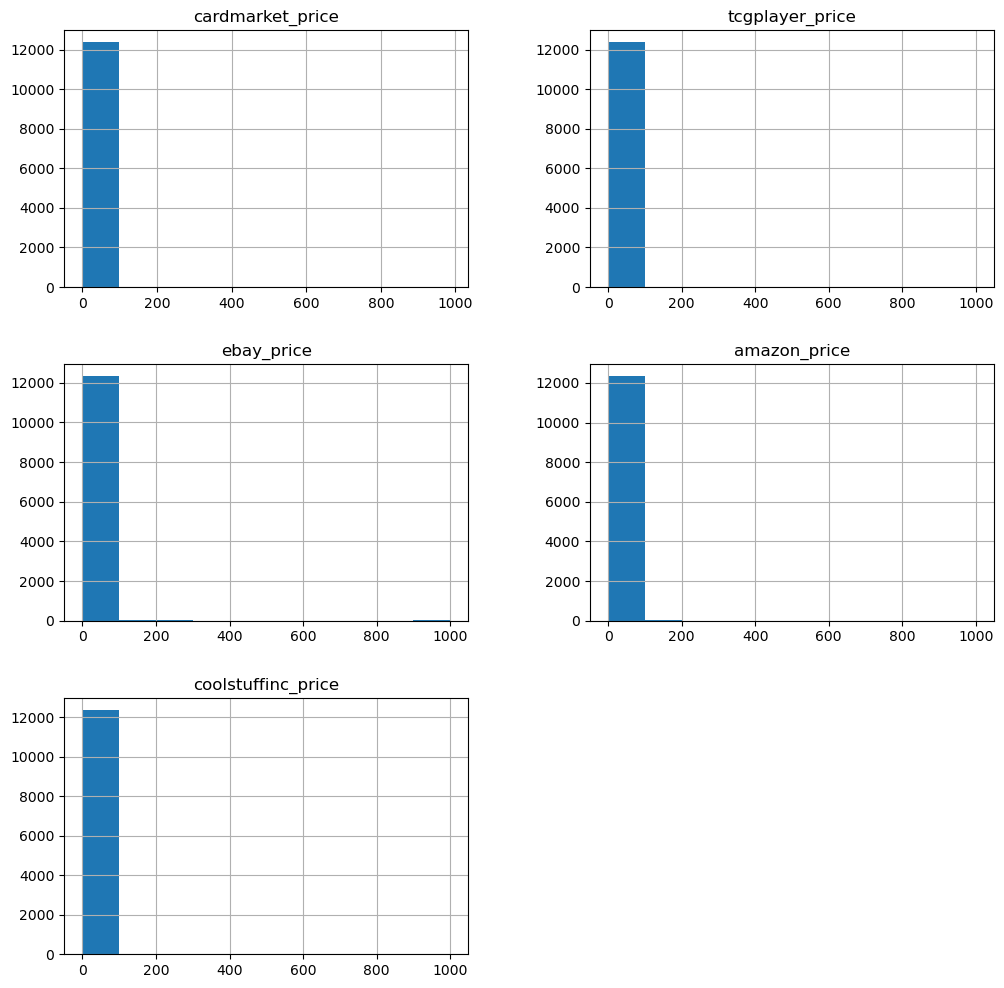

In [9]:
# Distribution of output data
card_df_val.iloc[:,16:].hist(figsize=(12,12),bins=10)

In [10]:
# Using only the price indices from tcgplayer
card_df_val=card_df_val.drop(['cardmarket_price','ebay_price','amazon_price','coolstuffinc_price'],axis=1)

# Removing outliers

In [12]:
topquantile=card_df_val.tcgplayer_price.quantile(0.99)
print('Top Quantile is: {}'.format(topquantile))


# Remove extreme outliers from both sides
card_df_val_final=card_df_val[card_df_val.tcgplayer_price>0]
card_df_val_final=card_df_val[card_df_val.tcgplayer_price<topquantile]
carddesc_final=carddesc[card_df_val.tcgplayer_price>0]
carddesc_final=carddesc[card_df_val.tcgplayer_price<topquantile]

card_df_val_final.describe()

Top Quantile is: 13.351600000000035


,type,race,archetype,atk,def,level,attribute,scale,linkval,banlist_info,cardlength,reprints,set_name,set_rarity,tcgplayer_price
count,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000
mean,10.203510,44.872245,144.190122,961.597878,771.102694,2.435429,2.336980,-0.854857,-0.895347,0.270612,51.803102,2.886857,146.970776,13.566776,0.536979
std,9.789188,20.822419,162.487810,1042.490957,914.842775,3.304349,2.375016,1.001588,0.611870,2.096962,28.814038,2.936690,126.917306,11.744219,1.225402
min,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,28.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,28.000000,1.000000,30.000000,2.000000,0.120000
50%,8.000000,49.500000,74.000000,600.000000,300.000000,3.000000,1.000000,-1.000000,-1.000000,0.000000,50.000000,2.000000,116.000000,13.000000,0.200000
75%,18.000000,59.000000,280.000000,1800.000000,1500.000000,4.000000,5.000000,-1.000000,-1.000000,0.000000,75.000000,3.000000,230.000000,27.000000,0.390000
max,27.000000,85.000000,494.000000,5000.000000,5000.000000,13.000000,7.000000,13.000000,6.000000,25.000000,237.000000,61.000000,484.000000,31.000000,13.330000


# Standardization

,name,type,race,archetype,atk,def,level,attribute,scale,linkval,banlist_info,cardlength,reprints,set_name,set_rarity,set_price,tcgplayer_price
0,"""A"" Cell Breeding Device",16,18,14,-1.0,-1.0,-1.0,0,-1.0,-1.0,0,16,1,195,2,1.31,0.19
1,"""A"" Cell Incubator",16,18,14,-1.0,-1.0,-1.0,0,-1.0,-1.0,0,32,1,206,2,2.1,0.24
2,"""A"" Cell Recombination Device",16,59,14,-1.0,-1.0,-1.0,0,-1.0,-1.0,0,66,1,217,2,1.12,0.20
3,"""A"" Cell Scatter Burst",16,59,14,-1.0,-1.0,-1.0,0,-1.0,-1.0,0,22,1,403,2,1.13,0.10
4,"""Infernoble Arms - Almace""",16,28,318,-1.0,-1.0,-1.0,0,-1.0,-1.0,0,89,2,160,19,0,0.64


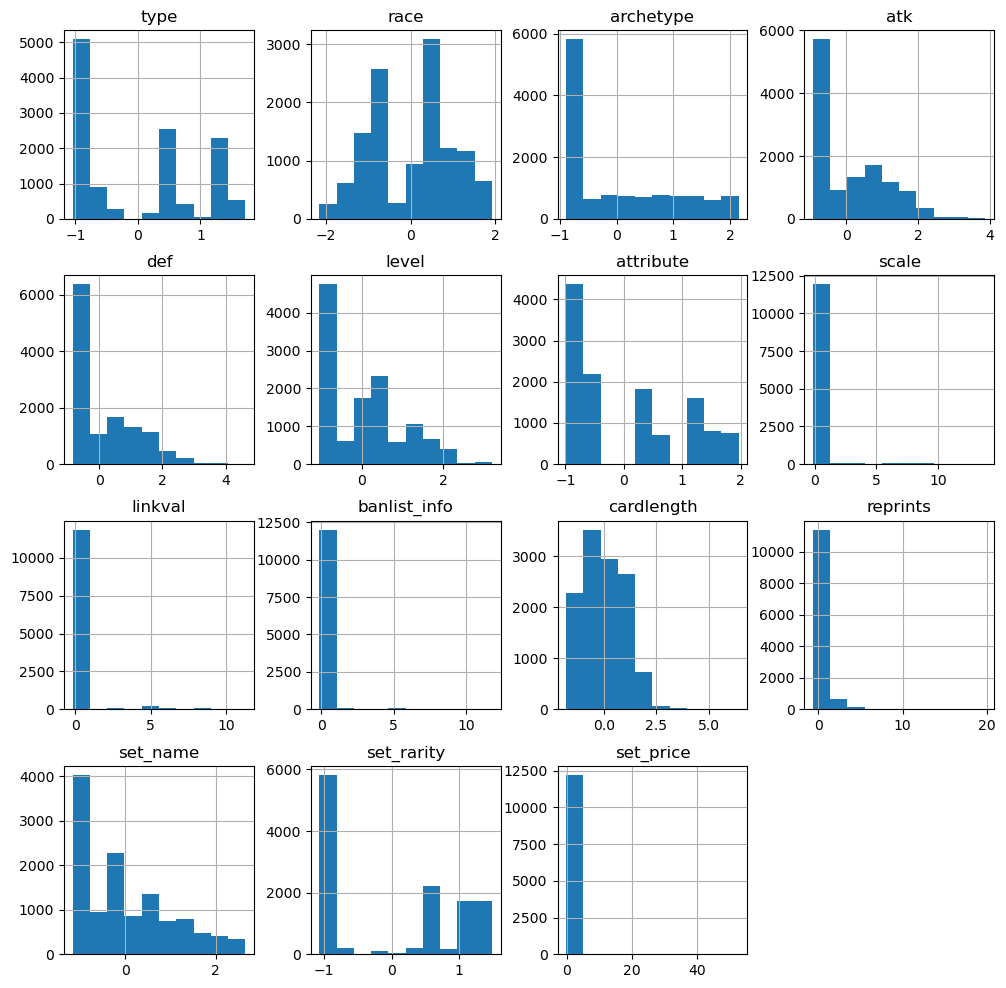

In [13]:
#Standardisation
np.random.seed(42)
scaler = StandardScaler()
columns=card_df.iloc[:,1:16].columns
X=card_df_val_final.iloc[:,1:16].to_numpy()
y=card_df_val_final.iloc[:,16].to_numpy()
X=np.double(X)
y=np.double(y)
# y=np.average(np.double(y),axis=1)
# print(y[0])

# X_scaled=X

X_scaled = scaler.fit_transform(X)
# print(X.shape)
X_df=pd.DataFrame(X_scaled,columns=columns)
X_df.hist(figsize=(12,12))
X_scaled[0]
card_df_val.head()

# Correlation Chart

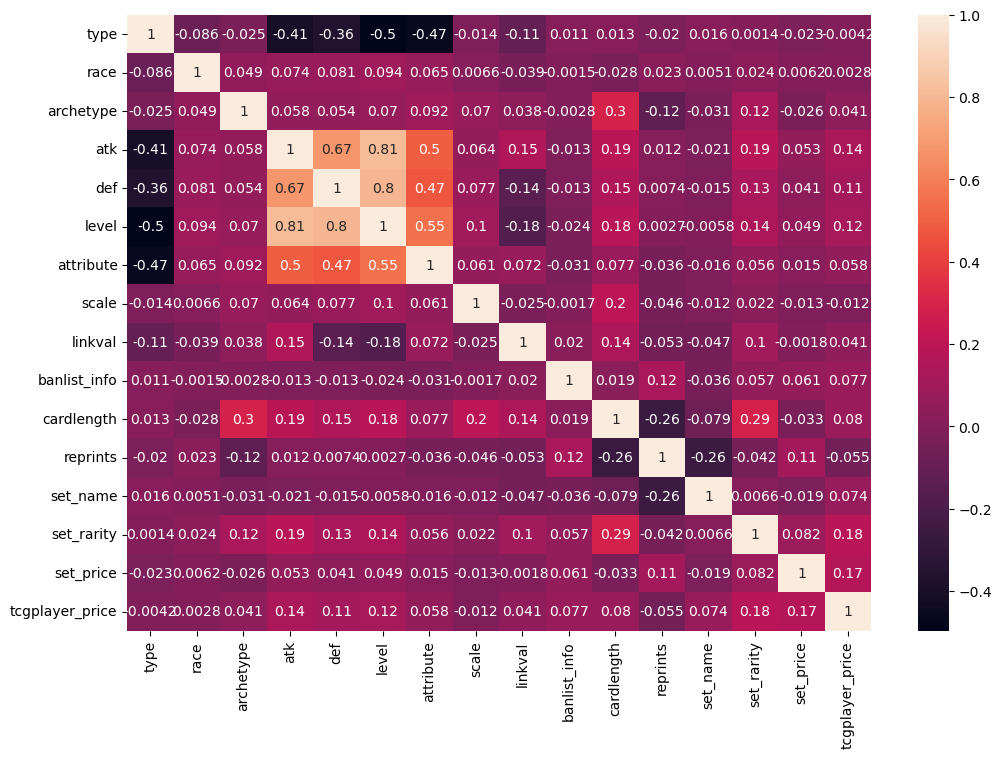

In [39]:
plt.figure(figsize=(12,8))
card_cor = card_df_val_final.iloc[:,1:17].corr()
sns.heatmap(card_cor, annot=True)
plt.show()

# Preprocessing for NLP features

In [40]:

lemmatizer=WordNetLemmatizer()

max_length=0
max_features=244


preproccessed_array=[]
method_bow=CountVectorizer(stop_words='english',lowercase=False, tokenizer=lambda x: x)
method_tfidf = TfidfVectorizer(stop_words='english', max_features=max_features,lowercase=False, tokenizer=lambda x: x)
for ind,x in enumerate(carddesc_final):
    lemmatized_singular_array=[]
    tokens=word_tokenize(x.lower().translate(str.maketrans('', '', string.punctuation)))
    for singular_token in tokens:
        lemmatized=(lemmatizer.lemmatize(singular_token))
        if(lemmatized_singular_array!=[]):
            if(lemmatized not in lemmatized_singular_array):
                lemmatized_singular_array.append(lemmatized)
        else:
            lemmatized_singular_array.append(lemmatized)
            
    if(max_length<len(lemmatized_singular_array)):
        # print(lemmatized_array)
        max_length=len(lemmatized_singular_array)
        # print(tokens)
    preproccessed_array.append(lemmatized_singular_array)

print(preproccessed_array[:5])

carddesc_tfidf=method_tfidf.fit_transform(preproccessed_array).toarray()
print(method_tfidf.vocabulary_)
print('Max Vocabulary Available= {}'.format(carddesc_tfidf.shape[1]))
# print(carddesc_tfidf[:5,:])

[['during', 'each', 'of', 'your', 'standby', 'phase', 'put', '1', 'acounter', 'on', 'faceup', 'monster', 'opponent', 'control'], ['each', 'time', 'an', 'acounters', 'is', 'removed', 'from', 'play', 'by', 'a', 'card', 'effect', 'place', '1', 'acounter', 'on', 'this', 'when', 'destroyed', 'distribute', 'the', 'among', 'faceup', 'monster'], ['target', '1', 'faceup', 'monster', 'on', 'the', 'field', 'send', 'alien', 'from', 'your', 'deck', 'to', 'graveyard', 'and', 'if', 'you', 'do', 'place', 'acounters', 'that', 'equal', 'level', 'of', 'sent', 'during', 'main', 'phase', 'except', 'turn', 'this', 'card', 'wa', 'can', 'banish', 'add', 'hand'], ['select', '1', 'faceup', 'alien', 'monster', 'you', 'control', 'destroy', 'it', 'and', 'distribute', 'new', 'acounters', 'equal', 'to', 'level', 'among', 'your', 'opponent'], ['while', 'this', 'card', 'is', 'equipped', 'to', 'a', 'monster', 'you', 'can', 'equip', '1', 'infernoble', 'arm', 'spell', 'from', 'your', 'deck', 'or', 'gy', 'appropriate', 'c

c:\Users\Sean\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Sean\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


{'standby': 202, 'phase': 158, '1': 2, 'faceup': 98, 'monster': 145, 'opponent': 151, 'control': 59, 'time': 214, 'removed': 174, 'play': 162, 'card': 50, 'effect': 88, 'place': 160, 'destroyed': 74, 'target': 212, 'field': 100, 'send': 188, 'deck': 67, 'graveyard': 107, 'equal': 91, 'level': 128, 'sent': 191, 'main': 142, 'turn': 223, 'wa': 231, 'banish': 39, 'add': 27, 'hand': 112, 'select': 186, 'destroy': 73, 'equipped': 93, 'equip': 92, 'spell': 196, 'gy': 108, 'warrior': 232, 'banished': 40, 'use': 228, '5': 16, 'lower': 137, 'special': 195, 'summon': 205, 'rest': 177, 'declare': 68, 'attack': 35, 'gain': 106, 'make': 143, 'second': 185, 'battle': 43, '4': 14, 'activate': 23, '3': 11, 'tribute': 219, '2': 8, 'draw': 85, 'flip': 102, '7': 20, 'directly': 79, 'increase': 118, 'life': 129, 'point': 164, 'atk': 31, 'def': 71, 'machine': 139, 'facedown': 97, 'defense': 72, 'position': 166, 'damage': 65, 'calculation': 49, 'choose': 54, 'trap': 217, 'instead': 122, 'treated': 218, '8':

## Split NLP dataset with respect to the price index

In [16]:
X_train_nlp,X_test_nlp,y_train_nlp,y_test_nlp=train_test_split(carddesc_tfidf,y, test_size=0.20, random_state=seed, shuffle=True)
X_test_nlp,X_valid_nlp,y_test_nlp,y_valid_nlp=train_test_split(X_test_nlp,y_test_nlp,test_size=0.50,random_state=seed, shuffle=True)

## Neural Networks for NLP

In [17]:
#Initialize hyperparameters
epochs=1600
D1=16
D2=16
D3=16
lr=1e-3
early_stopping=EarlyStopping(patience=100,monitor='val_loss')

#Initialize neural networks
my_nn_nlp=Sequential()
my_nn_nlp.add(Dense(D1,input_dim=X_train_nlp.shape[1],kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),activation='relu'))
# my_nn_nlp.add(BatchNormalization())
my_nn_nlp.add(Dense(D2,input_dim=D1,kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),activation='relu'))
# my_nn_nlp.add(Dropout(0.2))
# my_nn_nlp.add(BatchNormalization())
my_nn_nlp.add(Dense(D3,input_dim=D2,kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),activation='relu'))
# my_nn_nlp.add(Dropout(0.2))
# my_nn_nlp.add(BatchNormalization())
my_nn_nlp.add(Dense(1)) #Output shape is 1 because we're doing regression
print(my_nn_nlp.summary())
opt=keras.optimizers.Adam(learning_rate=lr)
my_nn_nlp.compile(loss='mean_squared_error', optimizer=opt,metrics=['mse'])
history=my_nn_nlp.fit(X_train_nlp,y_train_nlp,verbose=1,batch_size=64,epochs=epochs, validation_data=(X_test_nlp,y_test_nlp),callbacks=early_stopping)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                3920      
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4481 (17.50 KB)
Trainable params: 4481 (17.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/1600
154/154 [==============================] - 2s 4ms/step - loss: 1.5574 - mse: 1.5192 - val_loss: 1.8234 - val_mse: 1.7900
Epoch 2/1600
15

In [18]:
# Evaluate training phase
y_pred_nn_nlp_train = my_nn_nlp.predict(X_train_nlp)
y_pred_nn_nlp_true_train = y_pred_nn_nlp_train[:,0]

# Measure RMSE error and R2 score
score_nlp = metrics.r2_score(y_train_nlp,y_pred_nn_nlp_true_train)
print("Final score (R2): {}".format(metrics.r2_score(y_train_nlp,y_pred_nn_nlp_true_train)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_train_nlp,y_pred_nn_nlp_true_train))))

comparision_df_nn_nlp_train=pd.DataFrame({'Actual':y_train_nlp,'Pred':y_pred_nn_nlp_true_train})
comparision_df_nn_nlp_train.head()

307/307 [==============================] - 0s 1ms/step
Final score (R2): 0.824307720902791
Final score (RMSE): 0.511916025200484


,Actual,Pred
0,2.78,2.757560
1,0.07,0.332602
2,0.20,0.340046
3,0.35,0.110844
4,0.33,0.327175


In [19]:
#Evaluate testing phase
y_pred_nn_nlp = my_nn_nlp.predict(X_test_nlp)
y_pred_nn_nlp_true = y_pred_nn_nlp[:,0]

# Measure RMSE error and R2 score.  
score_nlp = metrics.r2_score(y_test_nlp,y_pred_nn_nlp_true)
print("Final score (R2): {}".format(metrics.r2_score(y_test_nlp,y_pred_nn_nlp_true)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_test_nlp,y_pred_nn_nlp_true))))

comparision_df_nn_nlp=pd.DataFrame({'Actual':y_test_nlp,'Pred':y_pred_nn_nlp_true})
comparision_df_nn_nlp.head()

# Evaluate validation phase
y_pred_nn_nlp_valid = my_nn_nlp.predict(X_valid_nlp)
y_pred_nn_nlp_valid = y_pred_nn_nlp_valid[:,0]
# Measure RMSE error.  
score_nlp = metrics.r2_score(y_valid_nlp,y_pred_nn_nlp_valid)
print("Final score (R2): {}".format(metrics.r2_score(y_valid_nlp,y_pred_nn_nlp_valid)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_valid_nlp,y_pred_nn_nlp_valid))))

comparision_df_nn_nlp_valid=pd.DataFrame({'Actual':y_valid_nlp,'Pred':y_pred_nn_nlp_valid})
comparision_df_nn_nlp_valid.head()

39/39 [==============================] - 0s 1ms/step
Final score (R2): -0.3114665632982574
Final score (RMSE): 1.5382796065128497
39/39 [==============================] - 0s 1ms/step
Final score (R2): -0.22876310928817456
Final score (RMSE): 1.2524379181742928


,Actual,Pred
0,2.85,0.321778
1,0.08,0.296368
2,3.34,0.719093
3,0.11,0.239722
4,0.09,0.327462


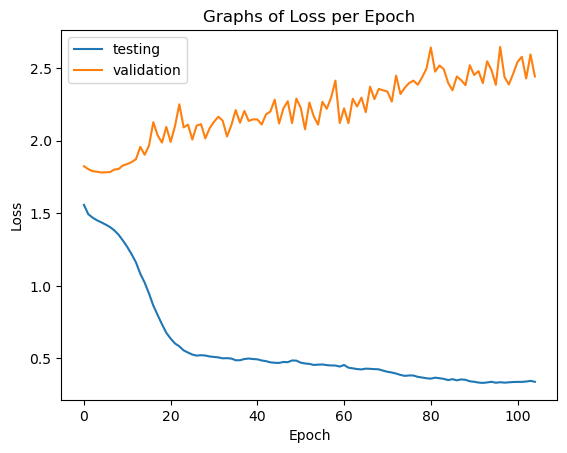

In [42]:
# Plotting loss per epoch
plt.plot(range(105),history.history['loss'])
plt.plot(range(105),history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Graphs of Loss per Epoch')
plt.legend(['testing','validation'])


# Random Forest for NLP

In [44]:
#Intitialize model
rf_nlp=RandomForestRegressor(n_estimators=50,random_state=seed)
rf_nlp.fit(X_train_nlp,y_train_nlp)

RandomForestRegressor(n_estimators=50, random_state=42)

In [45]:
#Evaluate training phase
ypred_rf_nlp_train=rf_nlp.predict(X_train_nlp)

# score_rf_nlp = metrics.r2_score(y_test_nlp,ypred_rf_nlp)
print("Final score (R2): {}".format(metrics.r2_score(y_train_nlp,ypred_rf_nlp_train)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_train_nlp,ypred_rf_nlp_train))))

comparision_df_rf_nn_nlp_train=pd.DataFrame({'Actual':y_train_nlp,'Pred':ypred_rf_nlp_train})
comparision_df_rf_nn_nlp_train.head()

Final score (R2): 0.788702822338609
Final score (RMSE): 0.5613958977847252


,Actual,Pred
0,2.78,2.103000
1,0.07,0.364200
2,0.20,0.357036
3,0.35,0.446491
4,0.33,0.339800


In [46]:
#Evaluate testing phase
ypred_rf_nlp=rf_nlp.predict(X_test_nlp)

print("Final score (R2): {}".format(metrics.r2_score(y_test_nlp,ypred_rf_nlp)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_test_nlp,ypred_rf_nlp))))

comparision_df_rf_nn_nlp=pd.DataFrame({'Actual':y_test_nlp,'Pred':ypred_rf_nlp})
comparision_df_rf_nn_nlp.head()

# Evaluate validation phase
ypred_rf_nlp_valid=rf_nlp.predict(X_valid_nlp)

# score_rf_nlp = metrics.r2_score(y_test_nlp,ypred_rf_nlp)
print("Final score (R2): {}".format(metrics.r2_score(y_valid_nlp,ypred_rf_nlp_valid)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_valid_nlp,ypred_rf_nlp_valid))))

comparision_df_rf_nn_nlp_valid=pd.DataFrame({'Actual':y_valid_nlp,'Pred':ypred_rf_nlp_valid})
comparision_df_rf_nn_nlp_valid.head()

Final score (R2): -0.0033341474769659207
Final score (RMSE): 1.345486882000612
Final score (R2): -0.02678110916118892
Final score (RMSE): 1.1448828780286426


,Actual,Pred
0,2.85,0.574800
1,0.08,0.399800
2,3.34,0.678854
3,0.11,0.159400
4,0.09,0.307926


<BarContainer object of 8 artists>

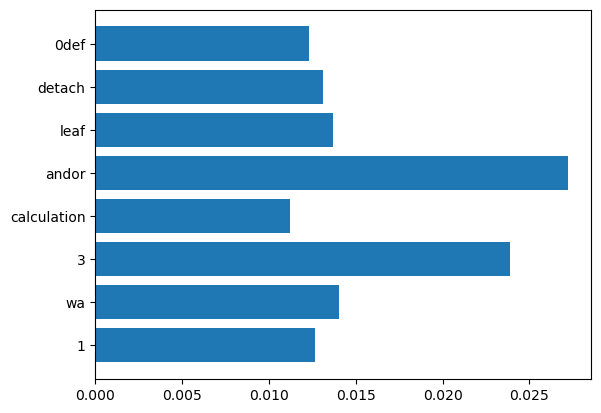

In [47]:
#Visuslise feature importances for Random Forest
columns_tfidf=list(method_tfidf.vocabulary_.keys())
gamma_nlp=rf_nlp.feature_importances_

threshold=0.01

#filter only significant features for readability
gamma_nlp_filtered=gamma_nlp[gamma_nlp>threshold]
columns_tfidf_filtered=np.array(columns_tfidf)[gamma_nlp>threshold]

plt.barh(columns_tfidf_filtered,gamma_nlp_filtered)


# Numerical Features Preprocessing

## Feature Selection using Random Forest Regressor

<BarContainer object of 15 artists>

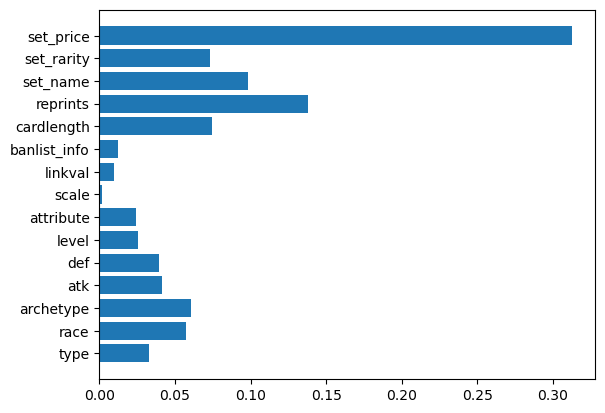

In [24]:
# Initialize model
forestreg=RandomForestRegressor(n_estimators=50,random_state=42)
forestreg.fit(X,y)

# Plot feature importances
gamma=forestreg.feature_importances_
plt.barh(columns,gamma)

In [25]:
#Remove unwanted features
threshold_numerical=0.06
X_filtered=X[:,gamma>threshold_numerical]
columns_filtered=columns[gamma>threshold_numerical]
print('number of columns after feature selection is: {}'.format(len(columns_filtered)))
print('columns picked are: {}'.format(columns_filtered))

number of columns after feature selection is: 6
columns picked are: Index(['archetype', 'cardlength', 'reprints', 'set_name', 'set_rarity',
       'set_price'],
      dtype='object')


# Split train and test set

In [26]:
#split the dataset, random_state for replication
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.20, random_state=seed, shuffle=True) 
X_test,X_valid,y_test,y_valid=train_test_split(X_test,y_test,test_size=0.50,random_state=seed, shuffle=True)

# Linear Regression (BASELINE)

In [27]:
linreg_model = LinearRegression()
linreg_model.fit(X_train,y_train)
ypred_linreg=linreg_model.predict(X_test)
ypred_linreg_valid=linreg_model.predict(X_valid)


# Comparision (Linear Regression)

In [28]:
comparision_df_linreg=pd.DataFrame({'Actual':y_test,'Pred':ypred_linreg})
comparision_df_linreg_valid=pd.DataFrame({'Actual':y_valid,'Pred':ypred_linreg_valid})
print('R2 test:', np.sqrt(metrics.r2_score(y_test, ypred_linreg)))
print('RMSE test:', np.sqrt(metrics.mean_squared_error(y_test, ypred_linreg)))

print('R2 valid:', np.sqrt(metrics.r2_score(y_valid, ypred_linreg_valid)))
print('RMSE valid:', np.sqrt(metrics.mean_squared_error(y_valid, ypred_linreg_valid)))
comparision_df_linreg.head(25)

R2 test: 0.2869711685180522
RMSE test: 1.2867513294236668
R2 valid: 0.22499251326397499
RMSE valid: 1.1008845877368716


,Actual,Pred
0,0.13,0.222943
1,0.47,0.254293
2,8.71,0.703478
3,0.16,0.479726
4,0.20,0.267896
5,0.25,0.841697
6,0.17,0.296165
7,0.17,0.284563
8,0.21,0.488150
9,0.92,1.052473


RMSE: 1.2867513294236668


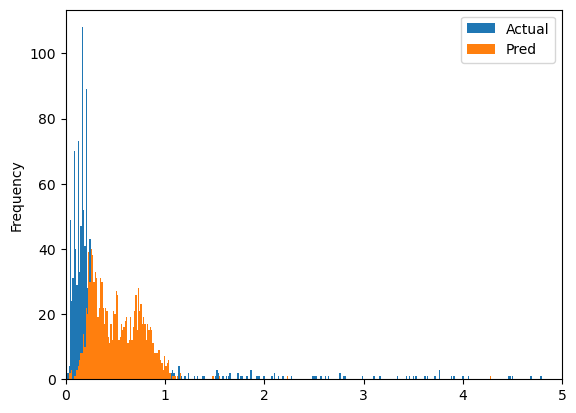

In [29]:
comparision_df_linreg.plot(kind='hist',bins=1000,xlim=(0,5))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred_linreg)))
# comparision_df_linreg['Actual']

## Random Forest Regressor For Numerical Features

<BarContainer object of 6 artists>

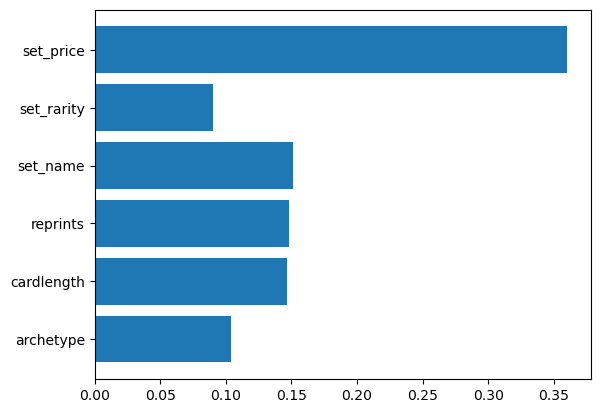

In [48]:
# Initialize model
forestreg=RandomForestRegressor(n_estimators=50,random_state=seed)
forestreg.fit(X_filtered,y)

gamma=forestreg.feature_importances_
plt.barh(columns_filtered,gamma)

In [32]:
# Evaluate training phase
ypred_forestreg_train=forestreg.predict(X_train)
comparision_df_forestreg_train=pd.DataFrame({'Actual':y_train,'Pred':ypred_forestreg_train})

print('R2 score:', metrics.r2_score(y_train, ypred_forestreg_train))
print('RMSE score:', np.sqrt(metrics.mean_squared_error(y_train, ypred_forestreg_train)))

R2 score: 0.9140651127577881
RMSE score: 0.35801987987220035


In [49]:
# Evaluate testing phase
ypred_forestreg=forestreg.predict(X_test)
comparision_df_forestreg=pd.DataFrame({'Actual':y_test,'Pred':ypred_forestreg})

print('R2 score:', metrics.r2_score(y_test, ypred_forestreg))
print('RMSE score:', np.sqrt(metrics.mean_squared_error(y_test, ypred_forestreg)))

ypred_forestreg_valid=forestreg.predict(X_valid)
comparision_df_forestreg_valid=pd.DataFrame({'Actual':y_valid,'Pred':ypred_forestreg_valid})

# Evaluate validation phase
print('R2 score:', metrics.r2_score(y_valid, ypred_forestreg_valid))
print('RMSE score:', np.sqrt(metrics.mean_squared_error(y_valid, ypred_forestreg_valid)))
comparision_df_forestreg_valid.head(25)

R2 score: 0.9235443815633916
RMSE score: 0.3714166547186785
R2 score: 0.8925485682076416
RMSE score: 0.37036354207279576


,Actual,Pred
0,2.85,1.852400
1,0.08,0.133200
2,3.34,2.950013
3,0.11,0.193800
4,0.09,0.098800
5,0.17,0.202000
6,0.16,0.206600
7,0.23,0.248000
8,0.74,0.845800
9,0.19,0.167000


<Axes: ylabel='Frequency'>

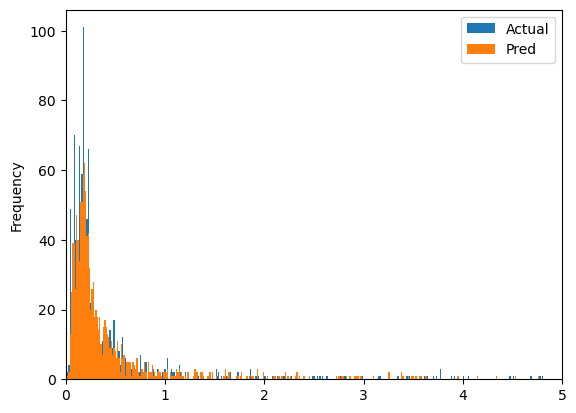

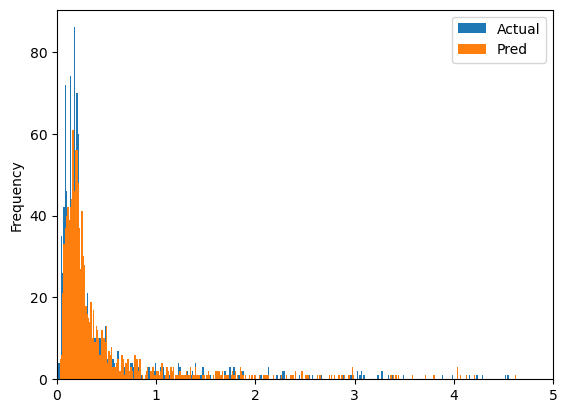

In [33]:
# Plot comparisions between predicted and actual values
comparision_df_forestreg.plot(kind='hist',bins=1000,xlim=(0,5))
comparision_df_forestreg_valid.plot(kind='hist',bins=1000,xlim=(0,5))

# Neural Networks for Numerical Features

In [70]:
# Initialise hyperparameters
early_stopping=EarlyStopping(patience=100,monitor='val_loss')
epochs=1600
D1=16
D2=16
D3=16
lr=1e-3

# Initialise model
my_nn=Sequential()
my_nn.add(Dense(D1,input_dim=X_filtered.shape[1],kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),activation='relu'))
# my_nn.add(BatchNormalization())
my_nn.add(Dense(D2,input_dim=D1,kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),activation='relu'))
# my_nn.add(Dropout(0.2))
# my_nn.add(BatchNormalization())
my_nn.add(Dense(D3,input_dim=D2,kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),activation='relu'))
# my_nn.add(Dropout(0.2))
# my_nn.add(BatchNormalization())
my_nn.add(Dense(1)) #Output shape is 1 because we're doing regression
print(my_nn.summary())

opt=keras.optimizers.Adam(learning_rate=lr)
my_nn.compile(loss='mean_squared_error', optimizer=opt,metrics=['mse'])
history2=my_nn.fit(X_train,y_train,verbose=1,batch_size=64,epochs=epochs, validation_data=(X_test,y_test),callbacks=early_stopping)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 16)                112       
                                                                 
 dense_17 (Dense)            (None, 16)                272       
                                                                 
 dense_18 (Dense)            (None, 16)                272       


                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 673 (2.63 KB)
Trainable params: 673 (2.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/1600
154/154 [==============================] - 2s 4ms/step - loss: 66.8558 - mse: 66.8408 - val_loss: 3.0989 - val_mse: 3.0855
Epoch 2/1600
154/154 [==============================] - 0s 2ms/step - loss: 2.4611 - mse: 2.4484 - val_loss: 2.2536 - val_mse: 2.2415
Epoch 3/1600
154/154 [==============================] - 0s 2ms/step - loss: 1.9418 - mse: 1.9299 - val_loss: 2.0736 - val_mse: 2.0620
Epoch 4/1600
154/154 [==============================] - 0s 2ms/step - loss: 1.7282 - mse: 1.7166 - val_loss: 1.8540 - val_mse: 1.8425
Epoch 5/1600
154/154 [==============================] - 0s 2ms/step - loss: 1.6317 - mse: 1.6202 

In [71]:
#Evaluate train phase
y_pred_nn_train = my_nn.predict(X_train)
y_pred_nn_train = y_pred_nn_train[:,0]
print("Final score (R2): {}".format(metrics.r2_score(y_train,y_pred_nn_train)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_train,y_pred_nn_train))))

307/307 [==============================] - 0s 1ms/step
Final score (R2): 0.40091680699990484
Final score (RMSE): 0.9452919395293311


In [72]:
# Evaluate Testing phase
y_pred_nn = my_nn.predict(X_test)
y_pred_nn = y_pred_nn[:,0]
# Measure RMSE error.  
print("Final score (R2): {}".format(metrics.r2_score(y_test,y_pred_nn)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_nn))))

comparision_df_nn=pd.DataFrame({'Actual':y_test,'Pred':y_pred_nn})

# Evaluate validation phase
y_pred_nn_valid = my_nn.predict(X_valid)
y_pred_nn_valid = y_pred_nn_valid[:,0]
# Measure RMSE error.  
print("Final score (R2): {}".format(metrics.r2_score(y_valid,y_pred_nn_valid)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_valid,y_pred_nn_valid))))

comparision_df_nn_valid=pd.DataFrame({'Actual':y_valid,'Pred':y_pred_nn_valid})
# comparision_df_nn_valid[comparision_df_nn_valid.Pred>0]

39/39 [==============================] - 0s 1ms/step
Final score (R2): 0.28436906633476544
Final score (RMSE): 1.1363214996245785
39/39 [==============================] - 0s 1ms/step
Final score (R2): 0.16015085616688007
Final score (RMSE): 1.0354348245558445


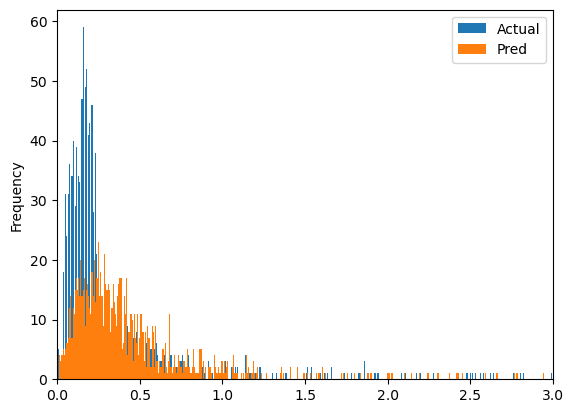

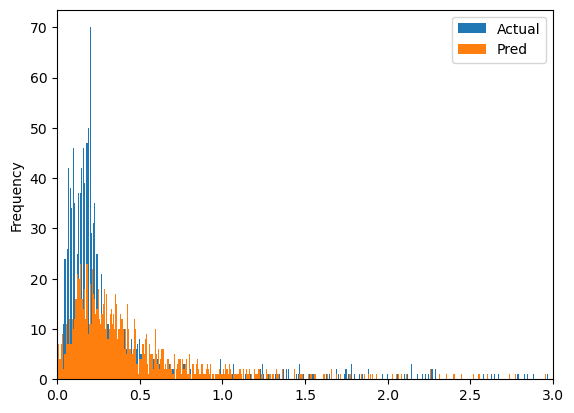

In [73]:
comparision_df_nn.plot(kind='hist',bins=2000,xlim=(0,3))
comparision_df_nn_valid.plot(kind='hist',bins=2000,xlim=(0,3))
plt.show()

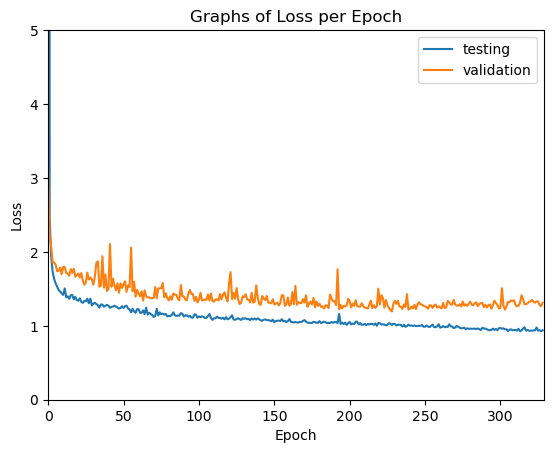

In [81]:
# Plotting loss per epoch
plt.plot(range(329),history2.history['loss'])
plt.plot(range(329),history2.history['val_loss'])
plt.axis([0,329,0,5])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Graphs of Loss per Epoch')
plt.legend(['testing','validation'])


# Combining NLP and Numerical Features

In [60]:
# Concatenate Features
X_concat=np.hstack((X_filtered,carddesc_tfidf))

In [61]:
#split the dataset, random_state for replication
print(X_concat.shape)
X_train_concat, X_test_concat, y_train_concat, y_test_concat = train_test_split(X_concat, y, test_size=0.20, random_state=seed, shuffle=True) 
X_test_concat,X_valid_concat,y_test_concat,y_valid_concat = train_test_split(X_test_concat,y_test_concat,test_size=0.5,random_state=seed, shuffle=True)

(12250, 250)


## Random Forest for Concatenated Features

In [62]:
# Initialize model
rf_concat=RandomForestRegressor(random_state=seed, n_estimators=50)
rf_concat.fit(X_train_concat,y_train_concat)

RandomForestRegressor(n_estimators=50, random_state=42)

In [64]:
ypred_rf_concat_train=rf_concat.predict(X_train_concat)
print("Final score (R2): {}".format(metrics.r2_score(y_train_concat,ypred_rf_concat_train)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_train_concat,ypred_rf_concat_train))))

Final score (R2): 0.9071687116548179
Final score (RMSE): 0.37210848717893596


In [63]:
# Initialize model
rf_concat=RandomForestRegressor(random_state=seed, n_estimators=50)
rf_concat.fit(X_train_concat,y_train_concat)

ypred_rf_concat=rf_concat.predict(X_test_concat)
print("Final score (R2): {}".format(metrics.r2_score(y_test_concat,ypred_rf_concat)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_test_concat,ypred_rf_concat))))

ypred_rf_concat_valid=rf_concat.predict(X_valid_concat)
print("Final score (R2): {}".format(metrics.r2_score(y_valid_concat,ypred_rf_concat_valid)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_valid_concat,ypred_rf_concat_valid))))

Final score (R2): 0.4191877006459048
Final score (RMSE): 1.023704408401689
Final score (R2): 0.260690808834103
Final score (RMSE): 0.9714829394955842


<BarContainer object of 8 artists>

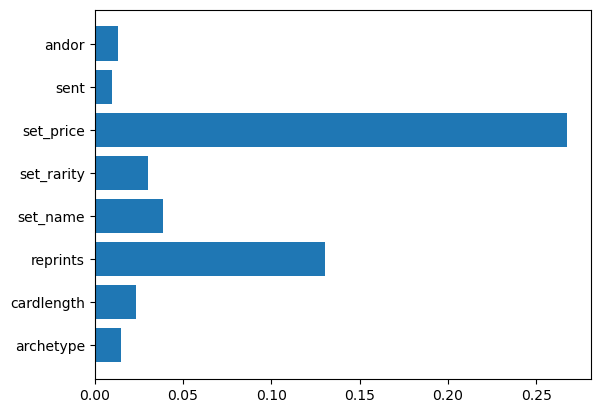

In [65]:
gamma_concat=rf_concat.feature_importances_
# print(gamma_concat.shape)
columns_nlp=list(method_tfidf.vocabulary_.keys())
# print(len(columns_nlp))
columns_concat=np.hstack((columns_filtered,columns_nlp))
columns_concat_filtered=columns_concat[gamma_concat>0.009]
gamma_concat_filtered=gamma_concat[gamma_concat>0.009]
plt.barh(columns_concat_filtered,gamma_concat_filtered)

## Neural Network for Concatenated Features

In [67]:
#Initialize hyperparameters
early_stopping=EarlyStopping(patience=100,monitor='val_loss')
epochs=1600
D1=16
D2=16
D3=16
lr=1e-3
# D3=128
# D4=64
my_nn2=Sequential()
my_nn2.add(Dense(D1,input_dim=X_concat.shape[1],kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),activation='relu'))
# my_nn2.add(BatchNormalization())
my_nn2.add(Dense(D2,input_dim=D1,kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),activation='relu'))
# my_nn2.add(Dropout(0.2))
# my_nn2.add(BatchNormalization())
my_nn2.add(Dense(D3,input_dim=D2,kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),activation='relu'))
# my_nn2.add(Dropout(0.2))
# my_nn2.add(BatchNormalization())
my_nn2.add(Dense(1)) #Output shape is 1 because we're doing regression
# print(my_nn.summary())
opt=keras.optimizers.Adam(learning_rate=lr)
my_nn2.compile(loss='mean_squared_error', optimizer=opt,metrics=['mse'])
history3=my_nn2.fit(X_train_concat,y_train_concat,verbose=1,batch_size=64,epochs=epochs, validation_data=(X_test_concat,y_test_concat),callbacks=early_stopping)

Epoch 1/1600
154/154 [==============================] - 2s 3ms/step - loss: 7.2721 - mse: 7.2298 - val_loss: 2.0019 - val_mse: 1.9634
Epoch 2/1600
154/154 [==============================] - 0s 2ms/step - loss: 1.6020 - mse: 1.5659 - val_loss: 1.9262 - val_mse: 1.8924
Epoch 3/1600
154/154 [==============================] - 0s 2ms/step - loss: 1.5369 - mse: 1.5048 - val_loss: 1.8748 - val_mse: 1.8443
Epoch 4/1600
154/154 [==============================] - 0s 2ms/step - loss: 1.4964 - mse: 1.4673 - val_loss: 1.7873 - val_mse: 1.7594
Epoch 5/1600
154/154 [==============================] - 0s 2ms/step - loss: 1.4714 - mse: 1.4447 - val_loss: 1.7923 - val_mse: 1.7667
Epoch 6/1600
154/154 [==============================] - 0s 2ms/step - loss: 1.4537 - mse: 1.4289 - val_loss: 1.7422 - val_mse: 1.7182
Epoch 7/1600
154/154 [==============================] - 0s 2ms/step - loss: 1.4400 - mse: 1.4167 - val_loss: 1.6921 - val_mse: 1.6695
Epoch 8/1600
154/154 [==============================] - 0s 2ms

In [68]:
#Evaluate training phase
y_pred_nn_train2 = my_nn2.predict(X_train_concat)
y_pred_nn_train2 = y_pred_nn_train2[:,0]
# Measure RMSE error.  
print("Final score (R2): {}".format(metrics.r2_score(y_train_concat,y_pred_nn_train2)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_train_concat,y_pred_nn_train2))))

comparision_df_nn_valid3=pd.DataFrame({'Actual':y_train_concat,'Pred':y_pred_nn_train2})

307/307 [==============================] - 1s 2ms/step
Final score (R2): 0.41118102866932305
Final score (RMSE): 0.9371590077761932


In [69]:
#Evaluating testing phase
y_pred_nn2 = my_nn2.predict(X_test_concat)
y_pred_nn2 = y_pred_nn2[:,0]
# Measure RMSE error.  
print("Final score (R2): {}".format(metrics.r2_score(y_test_concat,y_pred_nn2)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_test_concat,y_pred_nn2))))

comparision_df_nn2=pd.DataFrame({'Actual':y_test_concat,'Pred':y_pred_nn2})

#Evaluating validation phase
y_pred_nn_valid2 = my_nn2.predict(X_valid_concat)
y_pred_nn_valid2 = y_pred_nn_valid2[:,0]
# Measure RMSE error.  
print("Final score (R2): {}".format(metrics.r2_score(y_valid_concat,y_pred_nn_valid2)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_valid_concat,y_pred_nn_valid2))))

comparision_df_nn_valid2=pd.DataFrame({'Actual':y_valid_concat,'Pred':y_pred_nn_valid2})

39/39 [==============================] - 0s 2ms/step
Final score (R2): 0.2359686927467891
Final score (RMSE): 1.174119358597233
39/39 [==============================] - 0s 2ms/step
Final score (R2): 0.055758672720939706
Final score (RMSE): 1.0979021304208845


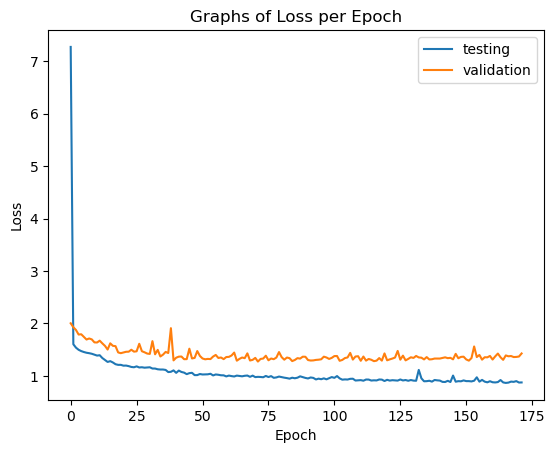

In [82]:
# Plotting loss per epoch
plt.plot(range(172),history3.history['loss'])
plt.plot(range(172),history3.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Graphs of Loss per Epoch')
plt.legend(['testing','validation'])
